In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import sys
sys.path.append('../..')
%load_ext autoreload
%autoreload 2

In [ ]:
! pip install -q --upgrade pip
! pip install -q matplotlib
!pip install -q torchsummary

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       # transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
from PIL import Image

train_data = train.train_data
# Convert the NumPy array to a PIL Image
# pil_image = Image.fromarray(train_data.numpy())
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [ ]:
from src.models import models

In [ ]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = models.NetFinal().to(device)
summary(model, input_size=(1, 28, 28))


# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [53]:
from torch.optim.lr_scheduler import StepLR

model =  models.NetWithGAP().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

Loss=0.11753023415803909 Batch_id=468 Accuracy=97.02: 100%|██████████| 469/469 [00:13<00:00, 33.96it/s]



Test set: Average loss: 0.1358, Accuracy: 9707/10000 (97.07%)

EPOCH: 4


Loss=0.11866685748100281 Batch_id=468 Accuracy=97.28: 100%|██████████| 469/469 [00:13<00:00, 34.43it/s] 



Test set: Average loss: 0.1306, Accuracy: 9706/10000 (97.06%)

EPOCH: 5


Loss=0.14765386283397675 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:13<00:00, 33.73it/s] 



Test set: Average loss: 0.1359, Accuracy: 9669/10000 (96.69%)

EPOCH: 6


Loss=0.09301644563674927 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:14<00:00, 33.22it/s] 



Test set: Average loss: 0.1445, Accuracy: 9599/10000 (95.99%)

EPOCH: 7


Loss=0.17740017175674438 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:14<00:00, 33.32it/s] 



Test set: Average loss: 0.1142, Accuracy: 9701/10000 (97.01%)

EPOCH: 8


Loss=0.08951479196548462 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:14<00:00, 33.29it/s] 



Test set: Average loss: 0.0900, Accuracy: 9759/10000 (97.59%)

EPOCH: 9


Loss=0.08058173954486847 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:14<00:00, 33.19it/s] 



Test set: Average loss: 0.0908, Accuracy: 9761/10000 (97.61%)

EPOCH: 10


Loss=0.0841665267944336 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:14<00:00, 32.76it/s]  



Test set: Average loss: 0.0848, Accuracy: 9789/10000 (97.89%)

EPOCH: 11


Loss=0.09505210071802139 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:13<00:00, 35.64it/s] 



Test set: Average loss: 0.0869, Accuracy: 9784/10000 (97.84%)

EPOCH: 12


Loss=0.06929659098386765 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:11<00:00, 42.13it/s] 



Test set: Average loss: 0.0864, Accuracy: 9784/10000 (97.84%)

EPOCH: 13


Loss=0.02739470638334751 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:12<00:00, 37.54it/s] 



Test set: Average loss: 0.0878, Accuracy: 9778/10000 (97.78%)

EPOCH: 14


Loss=0.10639947652816772 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:14<00:00, 32.39it/s] 



Test set: Average loss: 0.0880, Accuracy: 9774/10000 (97.74%)



Text(0.5, 1.0, 'Test Accuracy')

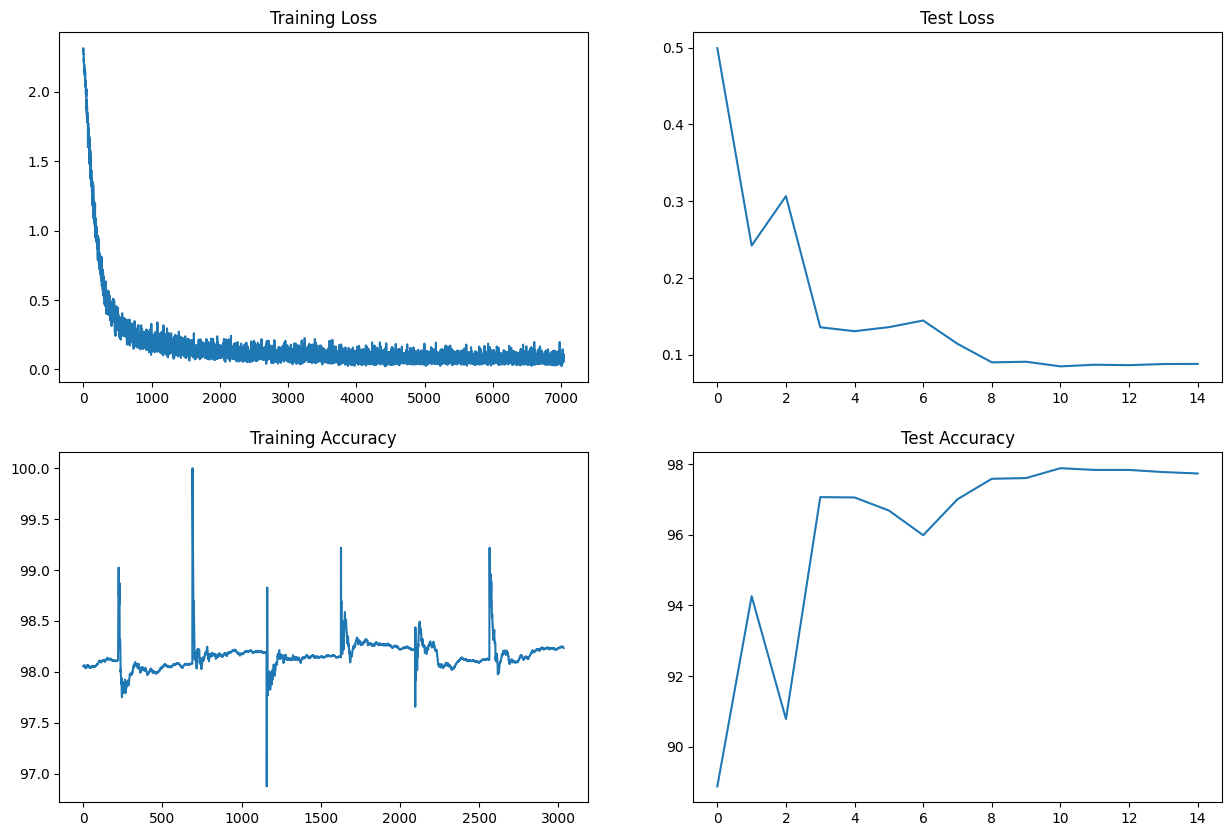

In [55]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Target
- Add LR Scheduler

## Results
- **Parameters:** 7.4k
- **Best Train Accuracy:** 98.23
- **Best Test Accuracy:** 
    - 97.89 (7th Epoch)


## Analysis
- Finding a good LR schedule is hard. We have tried to make it effective by reducing LR by the 10th after the 8th epoch.
- It did help in getting to 97.89 or faster, but the final accuracy is not more than 97.80. Possibly a good scheduler can do wonders here!

